In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os import listdir, makedirs, walk
from os.path import isdir, isfile, join, exists, expanduser
from tqdm import tqdm_notebook
import datetime
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
train_folder      = 'data/train/'
valid_folder      = 'data/validation/'

bottleneck_features_train_npy = 'bottleneck_features_train.npy'
bottleneck_features_valid_npy = 'bottleneck_features_valid.npy'
bottleneck_labels_train_npy = 'bottleneck_labels_train.npy'
bottleneck_labels_valid_npy = 'bottleneck_labels_valid.npy'

classes = [fldr for fldr in listdir(train_folder) if isdir(join(train_folder, fldr))]
num_classes = len(classes)
train_samples = sum([len(files) for r, d, files in walk(train_folder)])
valid_samples = sum([len(files) for r, d, files in walk(valid_folder)])

print ("Classes: {}, Training samples: {}, Validation samples: {}".format(num_classes, train_samples, valid_samples))

Classes: 26, Training samples: 188, Validation samples: 50


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


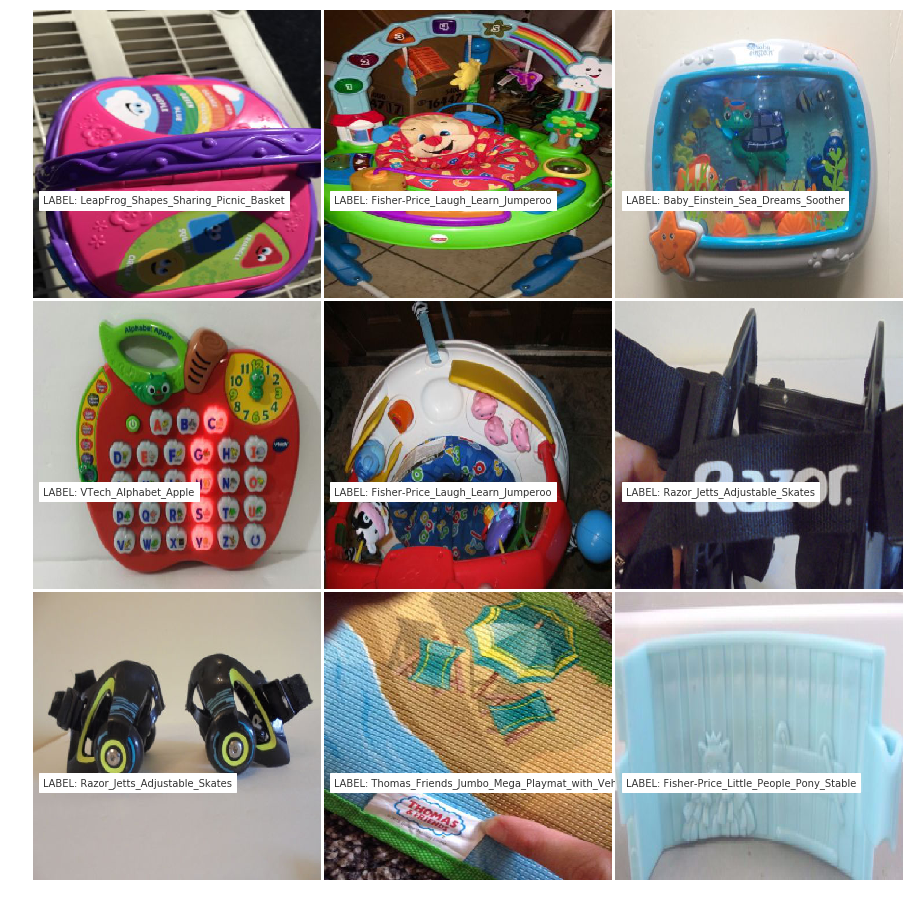

In [3]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# options
INPUT_SIZE = 299
BATCH_SIZE = 16

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

for i, cls in enumerate(np.random.choice(classes, 9)):
    ax = grid[i]
    img_file = np.random.choice(listdir(join(train_folder, cls)))
    img = image.load_img(join(train_folder, cls, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: %s' % cls, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

## Adapting [Kaggle log-reg example](https://www.kaggle.com/gaborfodor/dog-breed-pretrained-keras-models-lb-0-3) to use Keras data folder structure

In [4]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, deserialize
from keras.utils import to_categorical
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator, array_to_img

In [5]:
# Creating wrapper for input preprocessing from https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74 
def preprocess_input_xception(x):
    """Wrapper around keras.applications.xception.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.xception.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.xception import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [6]:
base_model = xception.Xception(weights='imagenet', include_top=False, pooling = 'avg')

In [7]:
if not exists(bottleneck_features_train_npy):
    # Set up data generator for bottleneck features - only need preprocessing (no augmentation)
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)

    # Generate bottleneck features for training data, and accompanying labels
    generator = datagen.flow_from_directory(
        train_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_train = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_train_npy, bottleneck_features_train)

    bottleneck_labels_train = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_train_npy, bottleneck_labels_train)
    
else:
    bottleneck_features_train = np.load(bottleneck_features_train_npy)
    bottleneck_labels_train = np.load(bottleneck_labels_train_npy)

Found 188 images belonging to 26 classes.
12/12 [==============================] - 176s 15s/step


In [8]:
if not exists(bottleneck_features_valid_npy):
    # Generate bottleneck features for validation data, and accompanying labels
    generator = datagen.flow_from_directory(
        valid_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_valid = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_valid_npy, bottleneck_features_valid)

    bottleneck_labels_valid = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_valid_npy, bottleneck_labels_valid)

else:
    bottleneck_features_valid = np.load(bottleneck_features_valid_npy)
    bottleneck_labels_valid = np.load(bottleneck_labels_valid_npy)    

Found 50 images belonging to 26 classes.
4/4 [==============================] - 46s 12s/step


In [10]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(bottleneck_features_train, (bottleneck_labels_train * range(num_classes)).sum(axis=1))
valid_probs = logreg.predict_proba(bottleneck_features_valid)
valid_preds = logreg.predict(bottleneck_features_valid)
print('Validation Xception LogLoss {}'.format(log_loss(bottleneck_labels_valid, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((bottleneck_labels_valid * range(num_classes)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 4.881027160609909
Validation Xception Accuracy 0.02


### Results from entire eBay imgs
```
Validation Xception LogLoss 2.0249956299062974
Validation Xception Accuracy 0.44568923526546517
```